# LLMS evaluation

## 1. Create simple RAG
I'm using Azure OpenAI implementations. The simple RAG code is based on a Ragas example and has been modified for educational purposes.

I have configured the llm_judge model to use a superior version, opting for o3 over o4. This follows best practices in LLM evaluation, where employing a higher-performing model as judge enhances result assessment

t is considered good practice to use a more advanced version of an LLM model as a judge. However, due to constraints related to permissions and costs, I have used the same version of the model as both the agent and the judge.

**Notes about env variables**
- _ENDPOINT_AZ_AI_: The _simple_rag_ library uses this environment variable, contains the Azure private endpoint of the model (AI Foundry)
- _AZURE_OPENAI_API_KEY_ variable is set in the system and is consumed by default in LangChain.



In [ ]:
import os
from langchain_openai import AzureChatOpenAI, ChatOpenAI
from langchain_openai import AzureOpenAIEmbeddings
from rag import simple_rag
#ragas libs for evaluation LLM
from ragas import evaluate, RunConfig
from ragas.llms import LangchainLLMWrapper
from ragas.metrics import LLMContextRecall, Faithfulness, FactualCorrectness

from ragas import EvaluationDataset

os.environ["RAGAS_DEBUG"] = "true"#to see the debug logs (useful for timeout problems with OpenAI API))
endpoint_az = os.environ["ENDPOINT_AZ_AI"]
run_config = RunConfig(timeout=200, log_tenacity=True)#this variable is used to set the timeout for the LLM calls. I have problemas with timeout < 180 in Azure 

# Initialize the RAG system 
llm_judge = AzureChatOpenAI(
    azure_endpoint= f'https://{endpoint_az}.cognitiveservices.azure.com/openai/deployments/gpt-4o-mini/chat/completions?api-version=2025-01-01-preview',#os.environ["AZURE_OPENAI_ENDPOINT"],
    azure_deployment='o4-mini_pv',
    openai_api_version='2024-12-01-preview')

embeddings_judge = AzureOpenAIEmbeddings(
    azure_endpoint= f'https://{endpoint_az}.cognitiveservices.azure.com/openai/deployments/text-embedding-3-large/embeddings?api-version=2023-05-15',#os.environ["AZURE_OPENAI_ENDPOINT"],
    azure_deployment='text-embedding-3-large',
    openai_api_version='2024-02-01')#embedding models judge is the same as the one used for the RAG

In [3]:
sample_docs = [
    "Google Inc published the transformative paper 'Attention is All You Need' in 2017, introducing the Transformer architecture that revolutionized natural language processing.",
    "Albert Einstein proposed the theory of relativity, which transformed our understanding of time, space, and gravity.",
    "Marie Curie was a physicist and chemist who conducted pioneering research on radioactivity and won two Nobel Prizes.",
    "Alan Turing is considered the father of computer science for his work on algorithms and computation. He introduced the turing test, a criterion of intelligence.",
    "Ada Lovelace is regarded as the first computer programmer for her work on Charles Babbage's early mechanical computer, the Analytical Engine.",
    "Microsoft was founded by Bill Gates and Paul Allen in 1975, revolutionizing personal computing with software like Windows and Office.",
]

### 1.1 Let's ask a question

In [5]:
# Initialize my local RAG instance
rag = simple_rag.RAG(endpoint_az)

# Load simulated documents
rag.load_documents(sample_docs)

# Query and retrieve the most relevant document
query = "Who is Alan Turing"
relevant_doc = rag.get_most_relevant_docs(query)

# Generate an answer
answer = rag.generate_answer(query, relevant_doc)

print(f"Query: {query}")
print(f"Relevant Document: {relevant_doc}")
print(f"Answer: {answer}")

Query: Who is Alan Turing
Relevant Document: ['Alan Turing is considered the father of computer science for his work on algorithms and computation. He introduced the turing test, a criterion of intelligence.']
Answer: Alan Turing is considered the father of computer science for his work on algorithms and computation. He introduced the Turing Test, which is a criterion of intelligence.


## 2. Evaluate the RAG with ragas

### 2.1 Collect evaluation dataset

In [6]:
sample_queries = [
    "Who introduced the theory of relativity?",
    "Who published the concept of the transformers",
    "What did Ada Lovelace?",
    "Who won two Nobel Prizes for research on radioactivity?",
    "Who is Alan Turing",
]

expected_responses = [
    "Albert Einstein proposed the theory of relativity, which transformed our understanding of time, space, and gravity.",
    "The concept of the transformers was published by Google Inc in the paper titled 'Attention is All You Need' in 2017.",
    "Ada Lovelace is regarded as the first computer programmer for her work on Charles Babbage's early mechanical computer, the Analytical Engine.",
    "Marie Curie won two Nobel Prizes for her research on radioactivity.",
    "Alan Turing is considered the father of computer science for his work on algorithms and computation. He introduced the Turing test, which is a criterion of intelligence."
]

In [7]:
dataset = []

for query,reference in zip(sample_queries,expected_responses):

    relevant_docs = rag.get_most_relevant_docs(query)
    response = rag.generate_answer(query, relevant_docs)
    dataset.append(
        {
            "user_input":query,
            "retrieved_contexts":relevant_docs,
            "response":response,
            "reference":reference
        }
    )

In [8]:
dataset[2]

{'user_input': 'What did Ada Lovelace?',
 'retrieved_contexts': ["Ada Lovelace is regarded as the first computer programmer for her work on Charles Babbage's early mechanical computer, the Analytical Engine."],
 'response': "Ada Lovelace is regarded as the first computer programmer for her work on Charles Babbage's early mechanical computer, the Analytical Engine.",
 'reference': "Ada Lovelace is regarded as the first computer programmer for her work on Charles Babbage's early mechanical computer, the Analytical Engine."}

In [ ]:
evaluation_dataset = EvaluationDataset.from_list(dataset)#define object for evaluation dataset

### 2.2 Execute evaluations using ragas methods

In [11]:
evaluator_llm = LangchainLLMWrapper(llm_judge)#judge llm 

result = evaluate(dataset=evaluation_dataset,metrics=[LLMContextRecall(), Faithfulness(), FactualCorrectness()],llm=evaluator_llm, run_config= run_config)
result

Evaluating:  80%|████████  | 12/15 [03:06<00:58, 19.34s/it]Exception raised in Job[5]: TimeoutError()
Exception raised in Job[8]: TimeoutError()
Evaluating: 100%|██████████| 15/15 [03:20<00:00, 13.33s/it]


{'context_recall': 1.0000, 'faithfulness': 1.0000, 'factual_correctness(mode=f1)': 0.8000}

The metrics used are:

**Context Recall**: How many of the relevant documents (or pieces of information) were successfully retrieved. It focuses on not missing important. The reference answer is analyzed to determine whether it can be attributed to the retrieved context or not. 

_"LLMContextRecall is computed using *user_input*, *reference* and the *retrieved_contexts*, and the values range between 0 and 1, with higher values indicating better performance. This metric uses reference as a proxy to reference_contexts"_

- _How can I interpret the result?_ Higher recall means fewer relevant documents were left out. the values range between 0 and 1
- _method_ ```LLMContextRecall()```.  is computed using user_input, reference and the retrieved_contexts. There is another method without LLM calls

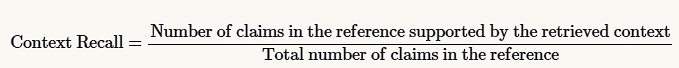

**Faithfulness**: How factually consistent a response is with the retrieved context. It ranges from 0 to 1, with higher scores indicating better consistency.

_"To calculate this: 1. Identify all the claims in the response. 2. Check each claim to see if it can be inferred from the retrieved context. 3. Compute the faithfulness score using the formula:"_

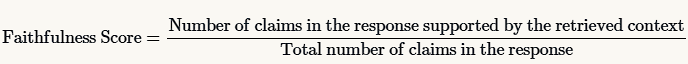

- _How can I interpret the result?_ A response is considered faithful if all its claims can be supported by the retrieved context.
- _method_ ```Faithfulness()```


## 3. Custom judges

### References
- https://docs.ragas.io/en/stable/getstarted/rag_eval/#basic-setup
- https://python.langchain.com/docs/integrations/chat/
- Private repositories
- https://docs.ragas.io/en/latest/concepts/metrics/available_metrics/context_recall/

#### Reference used to solve problems
- https://github.com/explodinggradients/ragas/issues/1247